In [1]:
import os

import matplotlib.pyplot as plt

import utils
from utils.func_yarotsky import get_func
from utils.plotting import plot_function_2d
from utils.plotting import plot_model_2d

from utils.comparison import get_training_dict
from utils.comparison import get_model
from utils.comparison import parse_log

In [2]:
cwd = os.getcwd()
log_path = cwd + '/logs/retrain/'

In [3]:
training_dict = get_training_dict(log_path)

names = list(training_dict.keys())
print(f"{'model' : <15}{'training time' : >15}{'mean mse' : >20}{'min mse' : >20}{'max mse' : >20}")
print(f'{"="*90}')
for i, key in enumerate(training_dict.keys()):
    print(f"{key: <15}{training_dict[key]['training_time']:>15.2f}{training_dict[key]['mean_mse']:>20.4e}{training_dict[key]['min_mse']:>20.4e}{training_dict[key]['max_mse']:>20.4e}")


model            training time            mean mse             min mse             max mse
height_1                 56.92          3.5088e-04          8.1551e-05          8.4183e-04
height_2                 67.01          1.4764e-05          1.0841e-05          1.9225e-05
height_3                120.30          8.6237e-06          4.8827e-06          1.5109e-05


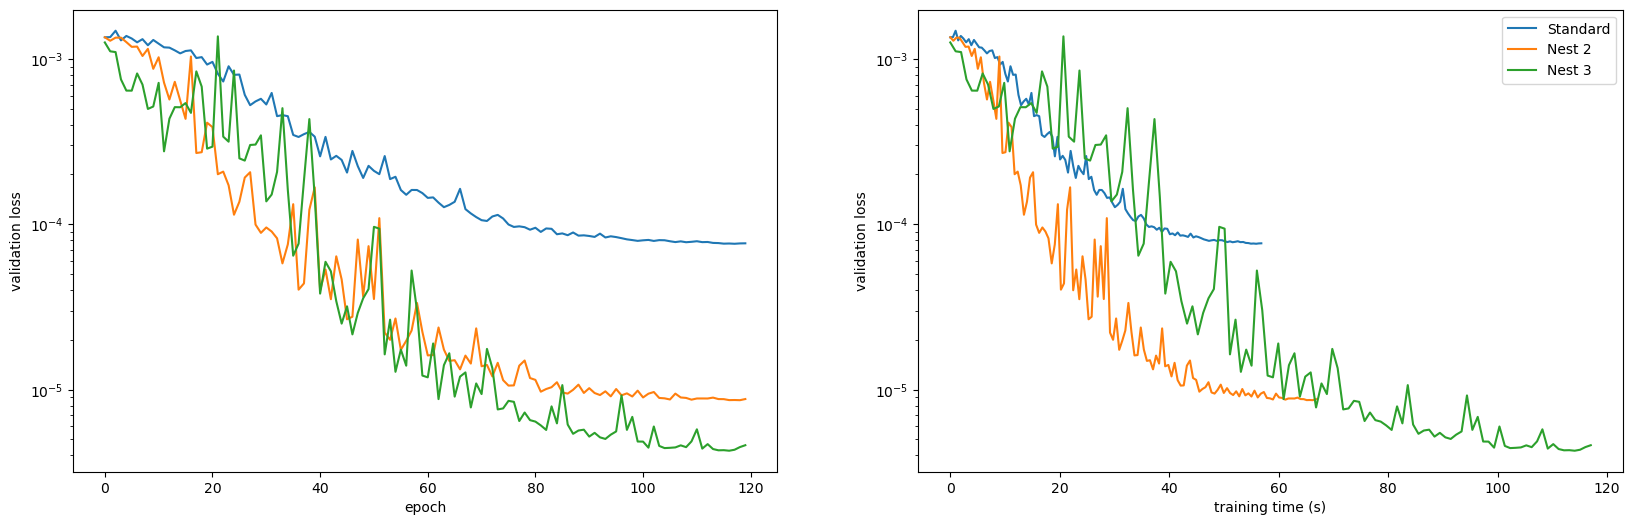

In [4]:
df_height1 = parse_log(height=1, cwd=cwd, training_dict=training_dict)
df_height2 = parse_log(height=2, cwd=cwd, training_dict=training_dict)
df_height3 = parse_log(height=3, cwd=cwd, training_dict=training_dict)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0].semilogy(df_height1['val_loss'])
axs[0].semilogy(df_height2['val_loss'])
axs[0].semilogy(df_height3['val_loss'])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('validation loss')

axs[1].semilogy(df_height1['wall_time'], df_height1['val_loss'], label='Standard')
axs[1].semilogy(df_height2['wall_time'], df_height2['val_loss'], label='Nest 2')
axs[1].semilogy(df_height3['wall_time'], df_height3['val_loss'], label='Nest 3')
axs[1].set_xlabel('training time (s)')
axs[1].set_ylabel('validation loss')
axs[1].legend()

plt.savefig(cwd + '/plot.png')

# Visualize target function and learned functions

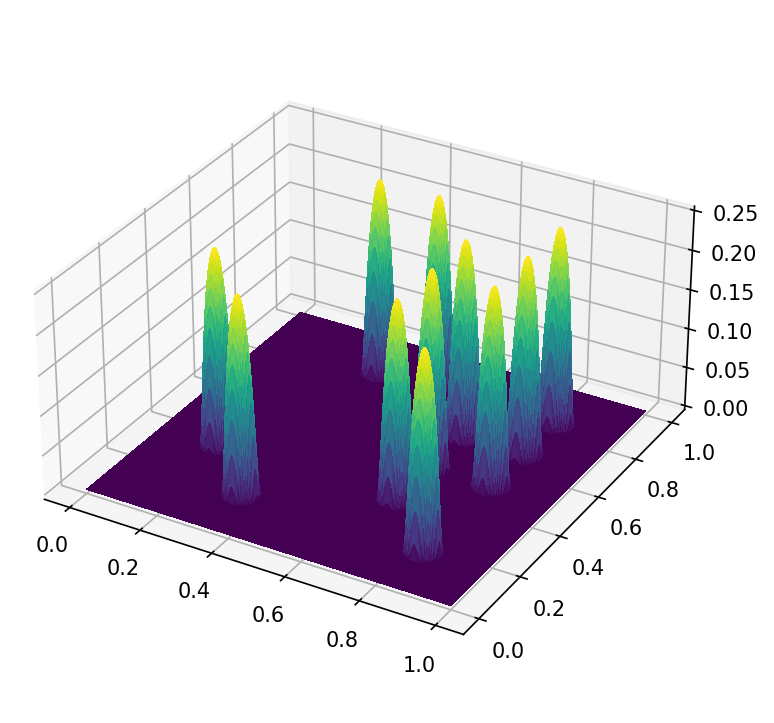

In [5]:
func = get_func(5)
plot_function_2d(func, path = cwd + '/function.png')

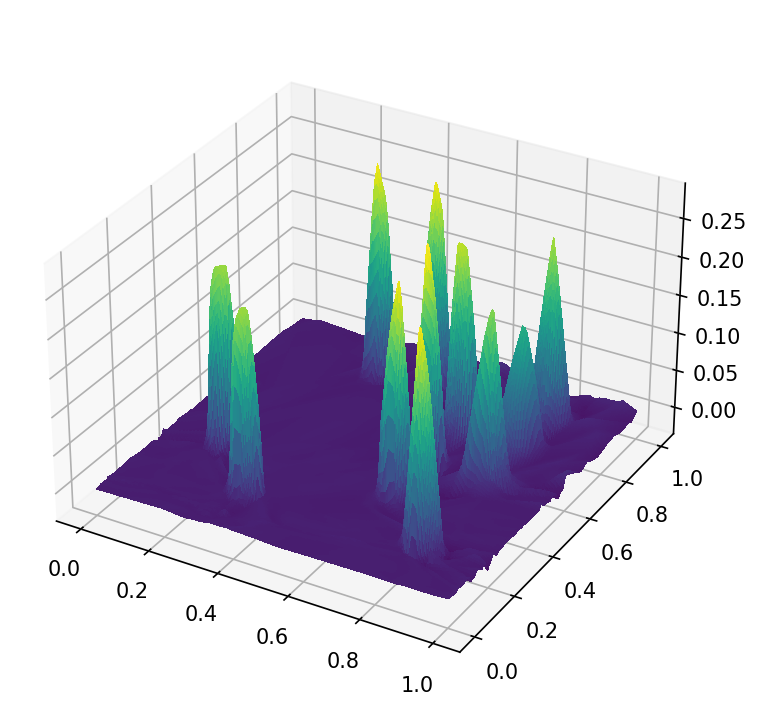

In [6]:
model_1 = get_model(height=1, cwd=cwd, training_dict=training_dict)
plot_model_2d(model_1, path = cwd + '/mlp.png')

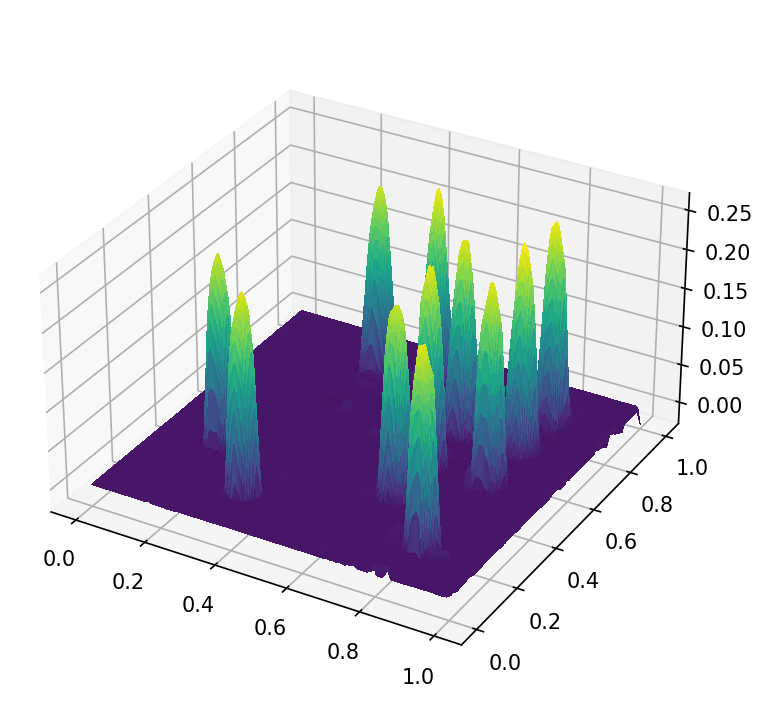

In [7]:
model_2 = get_model(height=2, cwd=cwd, training_dict=training_dict)
plot_model_2d(model_2, path = cwd + '/nest1.png')

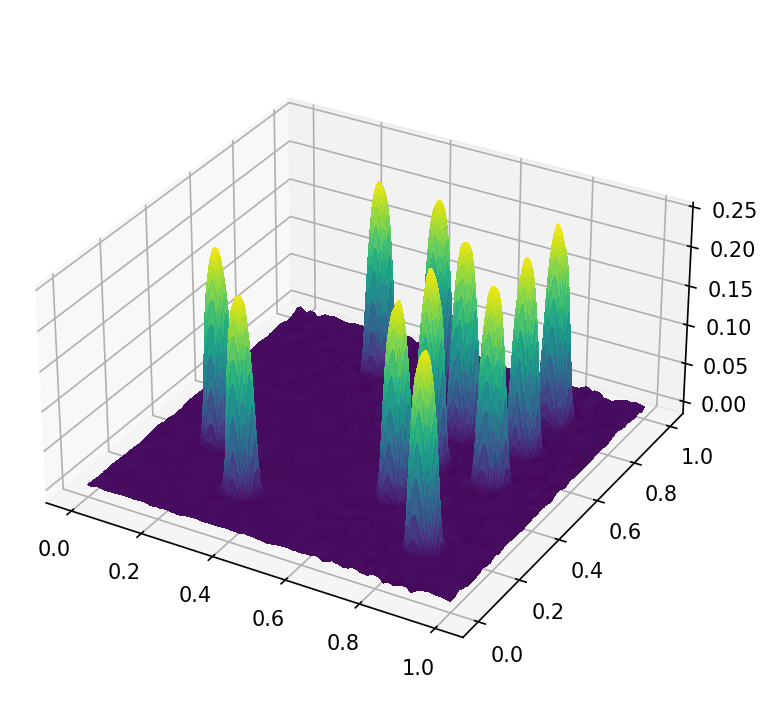

In [8]:
model_3 = get_model(height=3, cwd=cwd, training_dict=training_dict)
plot_model_2d(model_3, path = cwd + '/nest2.png')

In [9]:
%reload_ext tensorboard
%tensorboard --logdir="$log_path"